# PRAM linear models informed with EEG and pre-trial accuracy

Imports

In [1]:
import cmdstanpy
cmdstanpy.install_cmdstan()

/Users/anuszka/Projects/jointErrorCMD/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CmdStan install directory: /Users/anuszka/.cmdstan
Installing CmdStan version: 2.35.0
Download successful, file: /var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/tmpq0gxyxsp
Extracting distribution
Unpacked download as cmdstan-2.35.0
Building version cmdstan-2.35.0, may take several minutes, depending on your system.
Installed cmdstan-2.35.0
Test model compilation


True

In [2]:
from cmdstanpy import CmdStanModel
import os
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import json
import time
from contextlib import redirect_stdout
import seaborn as sns

## Define the model

In [105]:
name = 'acc_regression' 
model_name = f'{name}_model.stan'

print(f'Processing model: {model_name}')

Processing model: acc_regression_model.stan


## Compile the model

In [106]:
stan_file = os.path.join('../../models/rt_models/TBB_models/', model_name)
rt_model = CmdStanModel(
    stan_file=stan_file, 
    cpp_options={'STAN_THREADS': True}, 
    force_compile=True
)

18:24:21 - cmdstanpy - INFO - compiling stan file /Users/anuszka/Projects/jointErrorCMD/models/rt_models/TBB_models/acc_regression_model.stan to exe file /Users/anuszka/Projects/jointErrorCMD/models/rt_models/TBB_models/acc_regression_model
18:24:27 - cmdstanpy - INFO - compiled model executable: /Users/anuszka/Projects/jointErrorCMD/models/rt_models/TBB_models/acc_regression_model


In [107]:
rt_model.exe_info()

{'stan_version_major': '2',
 'stan_version_minor': '35',
 'stan_version_patch': '0',
 'STAN_THREADS': 'true',
 'STAN_MPI': 'false',
 'STAN_OPENCL': 'false',
 'STAN_NO_RANGE_CHECKS': 'false',
 'STAN_CPP_OPTIMS': 'false'}

## Define data file

In [108]:
data_file = os.path.join('../../data/', 'sonata_data_standarized_rt.json')

### Read the data

In [109]:
with open(data_file, 'r') as file:
    data = json.load(file)

In [110]:
data_df = pd.DataFrame(
    {
        'participant_index': data['participant'],
         'rt': abs(np.array(data['rt']))
    }
)

In [111]:
data_df

,participant_index,rt
0,1,0.309485
1,1,0.386673
2,1,0.316943
3,1,0.278136
4,1,0.316809
...,...,...
50415,222,0.306004
50416,222,0.211662
50417,222,0.260115
50418,222,0.292400


In [112]:
with pd.option_context('display.max_rows', None,):
    display(data_df.groupby('participant_index').describe())

rt                                                    \
                   count      mean       std       min       25%       50%   
participant_index                                                            
1                  204.0  0.281334  0.070878  0.122435  0.229762  0.269474   
2                  270.0  0.292436  0.055121  0.204357  0.255184  0.275872   
3                  249.0  0.310325  0.066462  0.183300  0.259806  0.294731   
4                  162.0  0.215983  0.051350  0.132320  0.184399  0.208774   
5                  233.0  0.291637  0.069109  0.125450  0.250441  0.272390   
6                  208.0  0.247580  0.052449  0.146695  0.215111  0.230018   
7                  267.0  0.336173  0.075972  0.139194  0.285392  0.320373   
8                  166.0  0.258189  0.072548  0.125095  0.208771  0.250628   
9                  253.0  0.288705  0.054690  0.178393  0.254461  0.275597   
10                 234.0  0.310498  0.067273  0.177115  0.264612  0.292011   
11                 222.0  0.264161  0.056102  0.163584  0.231120  0.246889   
12                 201.0  0.265823  0.056315  0.123722  0.229699  0.250386   
13                 272.0  0.304697  0.063174  0.174075  0.263974  0.292265   
14                 223.0  0.308631  0.083034  0.146081  0.251321  0.306289   
15                 202.0  0.256259  0.037247  0.174033  0.229638  0.250174   
16                 260.0  0.312989  0.065535  0.165090  0.268517  0.299817   
17                 246.0  0.292822  0.059059  0.122016  0.251750  0.282302   
18                 156.0  0.226513  0.053357  0.121574  0.195069  0.215729   
19                 251.0  0.287541  0.057323  0.153534  0.249400  0.276538   
20                 242.0  0.318788  0.064171  0.207101  0.280924  0.299129   
21                 181.0  0.272665  0.073285  0.130481  0.222439  0.250383   
22                 256.0  0.346439  0.081978  0.213836  0.285429  0.327020   
23                 243.0  0.271718  0.051385  0.167106  0.235270  0.261138   
24                 278.0  0.288219  0.045907  0.180633  0.257262  0.277890   
25                 241.0  0.340222  0.081148  0.141466  0.292336  0.336298   
26                 245.0  0.272469  0.063307  0.146565  0.229657  0.257368   
27                 208.0  0.258221  0.052112  0.178643  0.222431  0.243407   
28                 217.0  0.284622  0.069460  0.146635  0.241277  0.262081   
29                 206.0  0.265522  0.067200  0.125452  0.229622  0.250693   
30                 204.0  0.258408  0.057972  0.136051  0.219356  0.246609   
31                 147.0  0.254419  0.058139  0.132518  0.218941  0.250113   
32                 199.0  0.234974  0.049034  0.160705  0.208855  0.222684   
33                 213.0  0.269352  0.081636  0.152874  0.220284  0.246297   
34                 158.0  0.270836  0.077688  0.125611  0.208971  0.256403   
35                 210.0  0.250812  0.047852  0.160141  0.222404  0.243274   
36                 250.0  0.305484  0.074640  0.160111  0.257106  0.285093   
37                 257.0  0.301531  0.064939  0.147023  0.257609  0.292217   
38                 264.0  0.304149  0.060075  0.223034  0.264133  0.285182   
39                 241.0  0.300068  0.072177  0.167192  0.250720  0.277896   
40                 280.0  0.287232  0.057460  0.173695  0.243988  0.271076   
41                 251.0  0.276491  0.066623  0.171974  0.232279  0.255290   
42                 257.0  0.328935  0.073493  0.201867  0.275512  0.306216   
43                 182.0  0.361168  0.081133  0.243416  0.299417  0.330622   
44                 256.0  0.316534  0.068357  0.130884  0.271144  0.305838   
45                 226.0  0.331018  0.106498  0.122604  0.261173  0.303330   
46                 225.0  0.265424  0.061065  0.146202  0.229694  0.250651   
47                 151.0  0.261753  0.062767  0.134651  0.229625  0.243745   
48                 246.0  0.298207  0.059481  0.153982  0.257437  0.285450   
49                 201.0  0.252414  0.052797

## Fit the model

Fit parameters

In [113]:
num_chains = 1
warmup = 100
num_samples = 100
thin=1
adapt_delta=0.99
random_state = 42

Define initial values

In [114]:
n_participants = data['n_participants']

initials = []
for c in range(0, num_chains):
    chain_init = {               
        'mu_sd': np.random.uniform(.01, 1.),
        'cond_sd': np.random.uniform(.01, 1.),
        'ne_sd': np.random.uniform(.01, 1.),
        'acc_sd': np.random.uniform(.01, 1.),
        'ne_acc_sd': np.random.uniform(.01, 1.),

        'mu': np.random.uniform(0.1, .5),
        'cond': np.random.uniform(-0.1, .1),
        'ne': np.random.uniform(-0.1, .1),
        'acc': np.random.uniform(-0.1, .1),
        'ne_acc': np.random.uniform(-0.1, .1),

        'ne_cond': np.random.uniform(-0.1, .1),
        'acc_cond': np.random.uniform(-0.1, .1), 
        'ne_acc_cond': np.random.uniform(-0.1, .1),

        'sigma': np.random.uniform(.01, 1.),
        
        'participants_mu': np.random.uniform(0.1, .5, size=n_participants),
        'participants_cond': np.random.uniform(1, 2., size=n_participants),
        'participants_ne': np.random.uniform(-0.1, .1, size=n_participants),
        'participants_acc': np.random.uniform(-0.1, .1, size=n_participants),
        'participants_ne_acc': np.random.uniform(-0.1, .1, size=n_participants),
    }
    initials.append(chain_init)

Perform fit

In [115]:
with open('jupyter_logs.txt', 'a') as f:
    with redirect_stdout(f):
        start = time.time()
        fit = rt_model.sample(
            data=data_file,
            chains=num_chains, 
            seed=random_state,
            thin=thin,
            adapt_delta=adapt_delta,
            inits=initials, 
            iter_warmup=warmup, 
            iter_sampling=num_samples,
            parallel_chains=num_chains,
            threads_per_chain= 12,
            max_treedepth=10,
            show_progress=True,
            show_console=True,
            output_dir=f'../../results/pram_results/sonata/sonata_{name}_test/'
        )
        end = time.time()

print(f'Fitting took: {end - start}')

18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:27:04 - cmdstanpy - INFO - Chain [1] done processing
18:27:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'acc_regression_model.stan', line 74, column 4 to column 24)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'acc_regression_model.stan', line 74, column 4 to column 24)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'acc_regression_model.stan', line 74, column 4 to column 24)
18:27:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 10 divergent transitions (10.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Fitting took: 154.62921524047852


In [ ]:
print(fit.diagnose())

<Axes: xlabel='iter__', ylabel='mu_prop'>

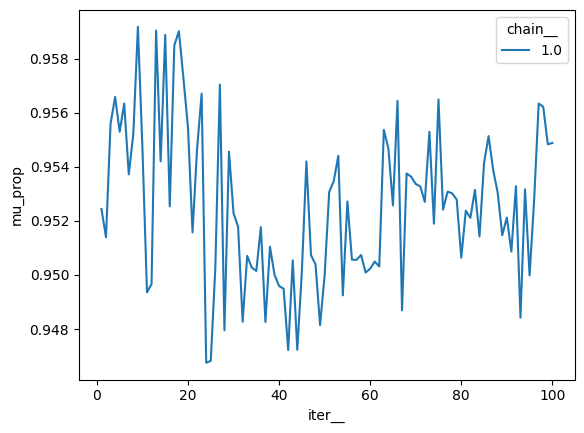

In [125]:
fit_df = fit.draws_pd()

sns.lineplot(
    data=fit_df,
    x = 'iter__',
    y = 'mu_prop',
    hue='chain__'
)

In [120]:
fit.summary().loc['mu_prop']

Mean        0.952585
MCSE        0.000675
StdDev      0.002915
5%          0.947948
50%         0.952571
95%         0.957274
N_Eff      18.623824
N_Eff/s     0.268944
R_hat       0.991859
Name: mu_prop, dtype: float64

In [121]:
fit.summary().loc['mu']

Mean        3.002132
MCSE        0.015146
StdDev      0.065200
5%          2.902050
50%         2.999920
95%         3.109270
N_Eff      18.531693
N_Eff/s     0.267613
R_hat       0.990732
Name: mu, dtype: float64

In [128]:
fit.summary().loc['pre_acc_prop']

Mean       -0.005980
MCSE        0.000421
StdDev      0.001849
5%         -0.009629
50%        -0.005632
95%        -0.003053
N_Eff      19.247468
N_Eff/s     0.277950
R_hat       1.019820
Name: pre_acc_prop, dtype: float64

Save the MCMC fit object

In [67]:
fit

CmdStanMCMC: model=rt_regression_model chains=1['method=sample', 'num_samples=10', 'num_warmup=10', 'thin=5', 'algorithm=hmc', 'engine=nuts', 'max_depth=10', 'adapt', 'engaged=1', 'delta=0.99']
 csv_files:
	../../results/pram_results/sonata/sonata_rt_regression_test/rt_regression_model-20240715171104.csv
 output_files:
	/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/tmp706fsypq/rt_regression_model8l_rvp49/rt_regression_model-20240715171104_0-stdout.txt

In [66]:
fit.save_csvfiles(dir=f'../../results/pram_results/sonata/sonata_{name}_test/')